# Task 1 Constructing the matrix X

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix


In [12]:
def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    h = 1  # Pixel distance
    x = np.linspace(-(M-1)/2, (M-1)/2, M)
    y = np.linspace(-(M-1)/2, (M-1)/2, M)
    Cx, Cy = np.meshgrid(x, y)
    C = np.vstack([Cx.ravel(), Cy.ravel()])
    
    i_indices = []
    j_indices = []
    weights = []
    
    for alpha in alphas:
        theta = np.deg2rad(alpha)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        p = R @ C
        p[0, :] += (Np-1) / 2
        
        for j in range(C.shape[1]):
            pj = p[:, j]
            sensor_idx = int(np.floor(pj[0]))
            if 0 <= sensor_idx < Np-1:
                i_indices.append(sensor_idx + (alphas.index(alpha) * Np))
                j_indices.append(j)
                weights.append(1 - (pj[0] - sensor_idx))
                
                i_indices.append(sensor_idx + 1 + (alphas.index(alpha) * Np))
                j_indices.append(j)
                weights.append(pj[0] - sensor_idx)
    
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(len(alphas) * Np, M * M), dtype=np.float32)
    
    # Debug: Check the shape and some values of X
    print(f"X shape: {X.shape}")
    print(f"Non-zero entries: {X.nnz}")
    print(f"Sample indices: {i_indices[:10]}, {j_indices[:10]}")
    print(f"Sample weights: {weights[:10]}")
    
    return X


X shape: (45, 100)
Non-zero entries: 600
Sample indices: [0, 1, 1, 2, 2, 3, 3, 4, 4, 5], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [0.22489321332203005, 0.77510678667797, 0.38622264537660556, 0.6137773546233944, 0.547552077431182, 0.45244792256881805, 0.7088815094857579, 0.2911184905142421, 0.8702109415403338, 0.12978905845966615]


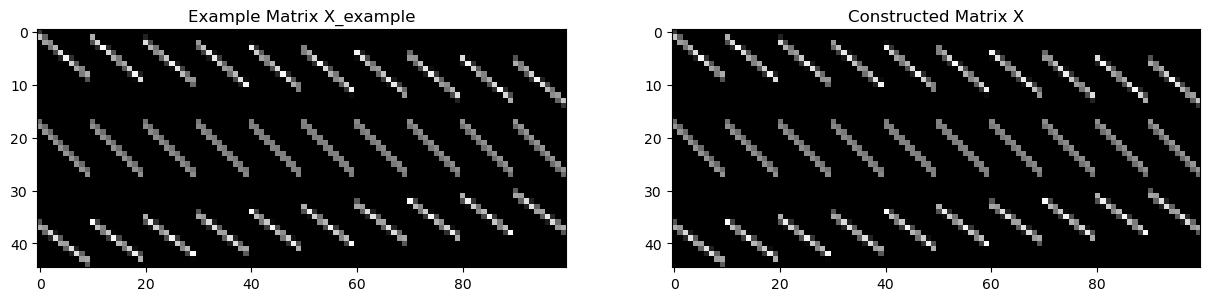

In [13]:

# Construct the matrix for the given parameters
M = 10
alphas = [-33, 1, 42]
X = construct_X(M, alphas)

# Load the example matrix
X_example = np.load('hs_tomography/X_example.npy')

# Convert sparse matrix X to dense format
X_dense = X.toarray()

# Visualize both matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(X_example, cmap='gray')
axes[0].set_title('Example Matrix X_example')

axes[1].imshow(X_dense, cmap='gray')
axes[1].set_title('Constructed Matrix X')

plt.show()

Both plots are as they seem identical, so i assume our function works fine.

### looking at the contructed matricies of M=77

In [15]:
directory = 'hs_tomography'

# M = 77 for small dataset 195 for bigger dataset
M = 77
Np = 109

# load the dataset
file_name_alpha = 'alphas_'+str(M)+'.npy'
file_name_y = 'y_'+str(M)+'.npy'

data_alpha = np.load(os.path.join(directory, file_name_alpha))
data_y = np.load(os.path.join(directory, file_name_y))
print("The shape of alpha: ", data_alpha.shape,'\n', "The shape of y:", data_y.shape)


# Convert data_alpha to a list
data_alpha_list = data_alpha.tolist()

# call function to construct X
X = construct_X(M, data_alpha_list)


The shape of alpha:  (90,) 
 The shape of y: (9810,)
X shape: (9810, 5929)
Non-zero entries: 1067220
Sample indices: [15, 16, 15, 16, 15, 16, 15, 16, 15, 16], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [0.6574038605596471, 0.34259613944035294, 0.639951454122361, 0.360048545877639, 0.6224990476850749, 0.3775009523149251, 0.605046641247796, 0.39495335875220405, 0.5875942348105099, 0.4124057651894901]


Range of values in X_dense: min=0.0, max=1.0


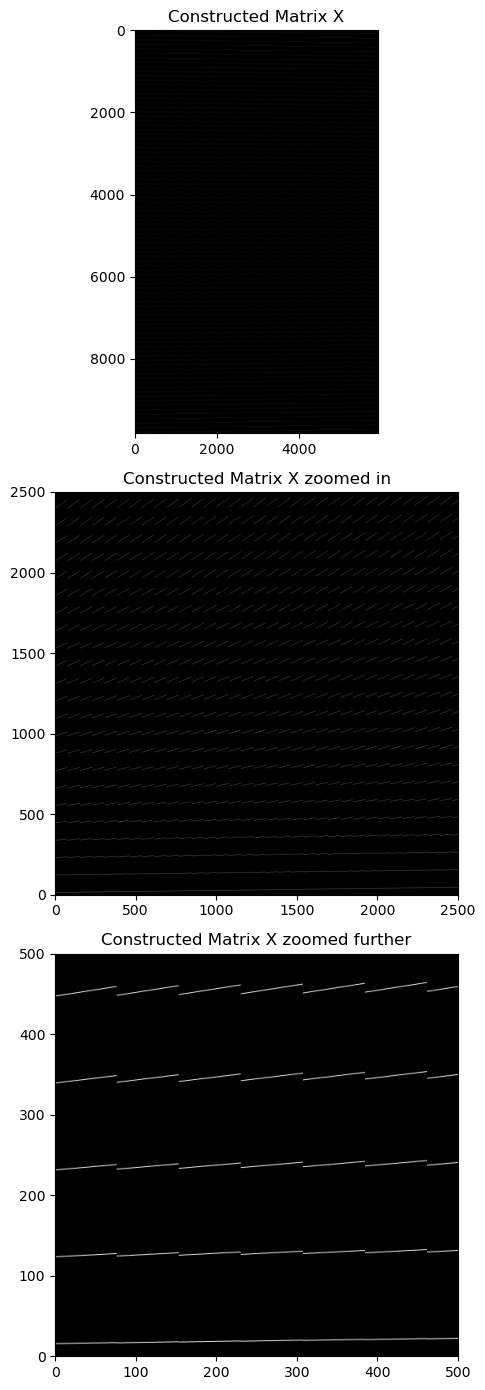

In [18]:
X_dense = X.toarray()

# Check the range of values in X_dense
print(f"Range of values in X_dense: min={X_dense.min()}, max={X_dense.max()}")

# Visualize both matrices with adjusted colormap limits if necessary
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# Visualize constructed matrix with colormap adjustment
axes[0].imshow(X_dense, cmap='gray', vmin=0, vmax=np.max(X_dense))
axes[0].set_title('Constructed Matrix X')
#axes[1].set_xlim(0,2500)
#axes[1].set_ylim(0,2500)

#Zoom in on the costructed matrix
axes[1].imshow(X_dense, cmap='gray', vmin=0, vmax=np.max(X_dense))
axes[1].set_title('Constructed Matrix X zoomed in')
axes[1].set_xlim(0,2500)
axes[1].set_ylim(0,2500)

axes[2].imshow(X_dense, cmap='gray', vmin=0, vmax=np.max(X_dense))
axes[2].set_title('Constructed Matrix X zoomed further')
axes[2].set_xlim(0,500)
axes[2].set_ylim(0,500)

plt.tight_layout()
plt.show()


# Task 2 Recovering the image

X shape: (49225, 38025)
Non-zero entries: 13612910
Sample indices: [40, 41, 40, 41, 40, 41, 40, 41, 40, 41], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]


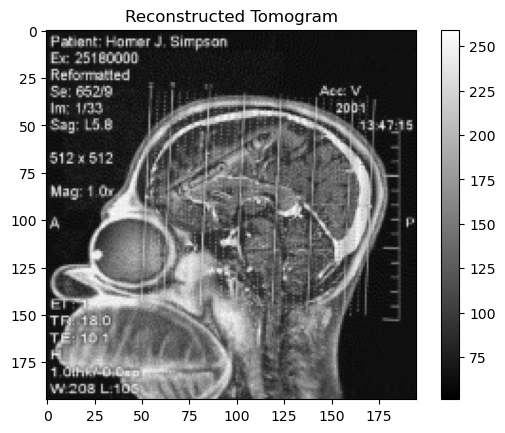

In [38]:
# Load the data
data_alpha = np.load('hs_tomography/alphas_195.npy')
data_y = np.load('hs_tomography/y_195.npy')

# Parameters
M = 195 #77
Np = 275 #109

# Convert data_alpha to a list
data_alpha_list = data_alpha.tolist()

# Construct the matrix X
X = construct_X(M, data_alpha_list, Np)

# Solve the least-squares problem
beta, istop, itn, r1norm = lsqr(X, data_y, atol=1e-06, btol=1e-06)[:4]

# Reshape the solution vector into a 2D image
beta_2D = beta.reshape((M, M))

# Plot the reconstructed tomogram
plt.imshow(beta_2D, cmap='gray')
plt.title('Reconstructed Tomogram')
plt.colorbar()
plt.show()

We can see, that Homer got something (i guess that is a pencil...) in his head, therefore indeed Homer has a reason for his headache. 
Probably Homer should lay down and not meet the Joker again.

# Tast 3 Minimizing the radiation dose

In [39]:
# Function to reconstruct the image with a given number of projections
def reconstruct_with_projections(M, data_alpha, y, Np):
    
    data_alpha_list = data_alpha.tolist()

    X = construct_X(M, data_alpha_list, Np)

    beta, istop, itn, r1norm = lsqr(X, y, atol=1e-06, btol=1e-06)[:4]
    beta_2D = beta.reshape((M, M))
    return beta_2D

# Load the big dataset
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')
M_large = 195
Np_large = 275

# Plot the reconstructed images with different numbers of projections
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(0,9):
    num_projections = (i+1)*15
    alphas_subset = alphas_195[:num_projections]
    y_subset = y_195[:num_projections * Np_large]
    beta_2D = reconstruct_with_projections(M_large, alphas_subset, y_subset, Np_large)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(beta_2D, cmap='gray')
    ax.set_title(f'{num_projections} Projections')
    ax.axis('off')
plt.tight_layout()
plt.show()


X shape: (4125, 38025)
Non-zero entries: 1140750
Sample indices: [40, 41, 40, 41, 40, 41, 40, 41, 40, 41], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
X shape: (8250, 38025)
Non-zero entries: 2281500
Sample indices: [40, 41, 40, 41, 40, 41, 40, 41, 40, 41], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
X shape: (12375, 38025)
Non-zero entries: 3422242
Sample indices: [40, 41, 40, 41, 40, 41, 40, 41, 40, 41], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
X shape: (16500, 38025)
Non-zero entries: 4562980
Sample indices: [40, 41, 40, 41, 40, 41, 40, 41, 40, 41], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
X shape: (20625, 38025)
Non-zero entries: 5703730
Sample indices: [40, 41, 40, 41, 40, 41, 40, 41, 40, 41], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [1.0, 0.0, 1.0, 0.0, 1.